# Validating PoolModel Data

I have a method to fetch what I believe will be the necessary data for the model from GNM_Pool.

Does the method work?
How does the data returned from that method look? 

In [1]:
import os
os.chdir("/home/charles/src/LondonMirror/Prepayments/")

In [2]:
import prepayments as pp
import numpy as np
import pandas as pd
import ggplot as gg
from datetime import datetime

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
pm = pp.models.PoolModel()

In [4]:
samples = [(pm.data_pool.h5file.root.pools[i]['pool_number'],
            datetime.fromtimestamp(pm.data_pool.h5file.root.pools[i]['as_of_date']))
           for i in np.random.choice(14151801,1000)]

In [5]:
ans = pm.data_for_pool_number(*samples[4])

ERROR:root:Weighted Average Coupon is missing for AC6820, 2015-11-01


In [6]:
ans

In [5]:
data = {(i,dt):pm.data_for_pool_number(i,dt) for i,dt in samples}

ERROR:root:No CPR data for 36210HD58
ERROR:root:No CPR data for 36211W2W7
ERROR:root:No CPR data for 36209KD54
ERROR:root:No CPR data for 36292JY45
ERROR:root:No CPR data for 36209HUE3
ERROR:root:No CPR data for 36210DWB3
ERROR:root:No CPR data for 362100TK5
ERROR:root:Weighted Average Coupon is missing for 781300, 2014-04-01
ERROR:root:Weighted Average Coupon is missing for AL3249, 2016-02-01
ERROR:root:No CPR data for 36207HZN0
ERROR:root:Weighted Average Coupon is missing for AF3651, 2014-01-01
ERROR:root:Weighted Average Coupon is missing for 664659, 2014-04-01
ERROR:root:Weighted Average Coupon is missing for 563807, 2014-02-01
ERROR:root:No CPR data for 362195KV0
ERROR:root:Weighted Average Coupon is missing for AB1201, 2016-03-01
ERROR:root:No CPR data for 36204HAF7
ERROR:root:Weighted Average Coupon is missing for 781228, 2015-02-01
ERROR:root:No CPR data for 36224JA28
ERROR:root:Weighted Average Coupon is missing for 214227, 2015-11-01
ERROR:root:Weighted Average Coupon is mis

In [6]:
missing = [(i,dt) for (i,dt),v in data.items() if v is None]

In [7]:
len(missing)

146

15% have missing data.

In [8]:
data = {k:v for k,v in data.items() if v is not None}

In [9]:
data = pd.DataFrame.from_dict(data, orient='index')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 854 entries, (001364, 2016-01-01 00:00:00) to (MA2491, 2016-04-01 00:00:00)
Data columns (total 9 columns):
upfront_mip    854 non-null float64
lockin         854 non-null float64
seasonality    854 non-null int64
burnout        854 non-null float64
incentive      854 non-null float64
cato           782 non-null float64
hpa            854 non-null float64
endo           854 non-null float64
sato           854 non-null float64
dtypes: float64(8), int64(1)
memory usage: 69.7+ KB


... 21% have missing data. Missing cato should just return None for the whole set.

In [11]:
data = data.dropna()

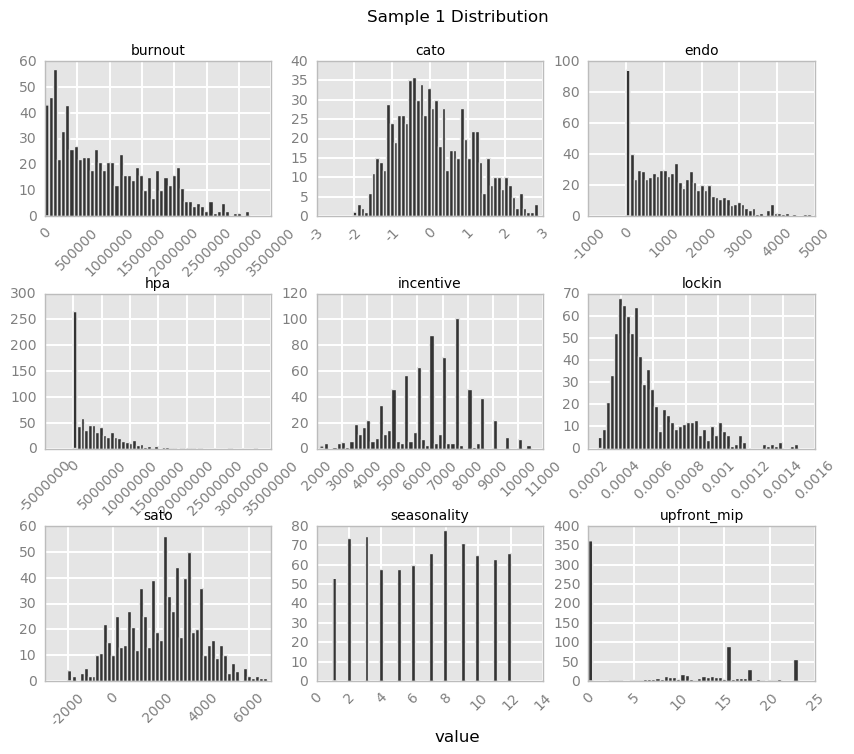

<ggplot: (8730273965745)>

In [35]:
p = gg.ggplot(pd.melt(data), gg.aes(x='value',group='variable')) + gg.facet_wrap(y='variable', scales="free")
p + gg.geom_histogram(bins=50) + gg.theme(x_axis_text=gg.element_text(angle=45)) + gg.ggtitle("Sample 1 Distribution")

Was 1000 a sufficient sample? Let's look at a second dataset

In [37]:
samples2 = [(pm.data_pool.h5file.root.pools[i]['pool_number'],
            datetime.datetime.fromtimestamp(pm.data_pool.h5file.root.pools[i]['as_of_date']))
           for i in np.random.choice(14151801,1000)]
data2 =  {(i,dt):pm.data_for_pool_number(i,dt) for i,dt in samples2}

ERROR:root:Weighted Average Coupon is missing for AB0757, 2013-08-01
/usr/lib/python2.7/dist-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: '36213CUH1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python2.7/dist-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: '36213CUH1_kind'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/usr/lib/python2.7/dist-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: '36213CUH1_meta'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr

AttributeError: 'DataFrame' object has no attribute 'items'

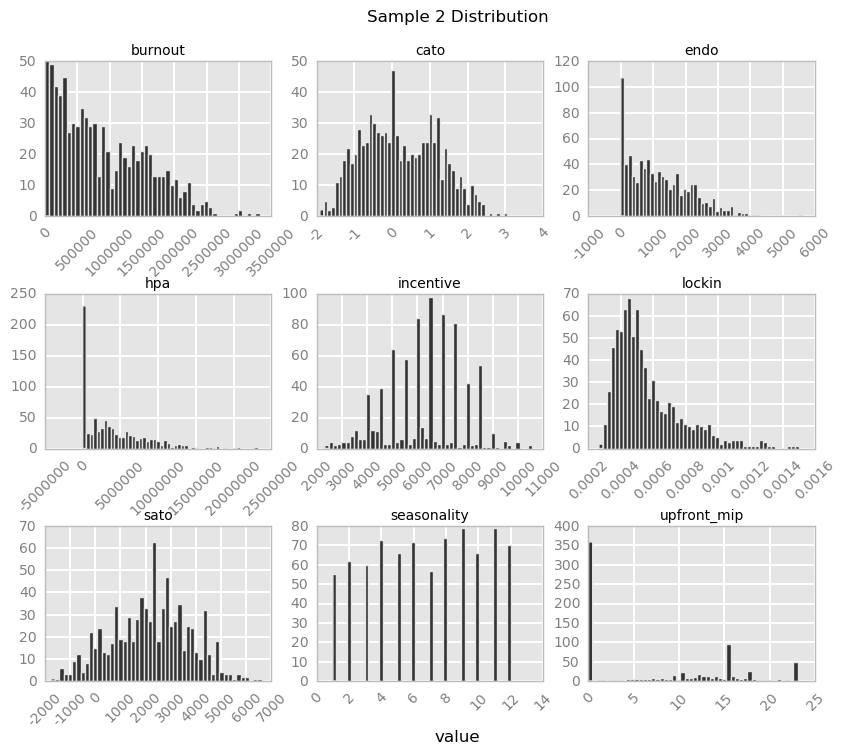

<ggplot: (8730274796193)>

In [38]:
missing2 = [(i,dt) for (i,dt),v in data2.items() if v is None]
data2 = pd.DataFrame.from_dict({k:v for k,v in data2.items() if v is not None}, orient='index').dropna()
p = gg.ggplot(pd.melt(data2), gg.aes(x='value',group='variable')) + gg.facet_wrap(y='variable', scales="free")
p + gg.geom_histogram(bins=50) + gg.theme(x_axis_text=gg.element_text(angle=45)) + gg.ggtitle("Sample 2 Distribution")

`cato` and esp. `burnout` a bit different, otherwise looking good.

So, how does one characterise these distributions?

* Why is the scale on `hpa` so high?
* What's with the peaks on `incentive`?
* Peaks on `sato` are less peaky. They ok?
* Get a set of scalars to put all factors in the same order of magnitude (except seasonality)

### What's with the scale on `hpa`?

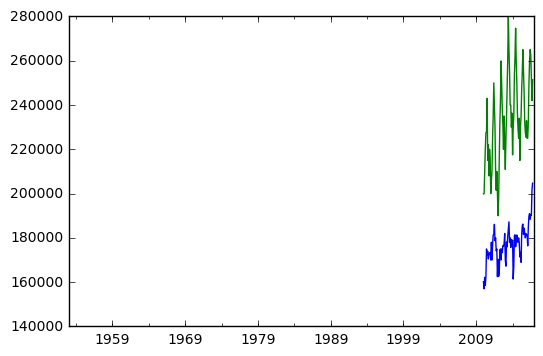

In [43]:
pm.data_hpa.get_returns_for_state("NM").plot()
pm.data_hpa.get_returns_for_state("VA").plot()

In [48]:
pm.data_pool.msas_table[0]["first_msa"]

28140

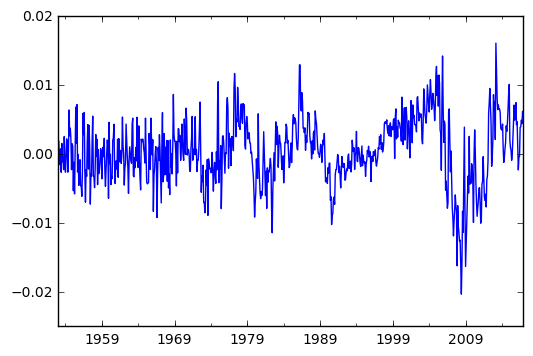

In [49]:
pm.data_hpa.get_returns_for_msa_code(msa_code=None).plot()

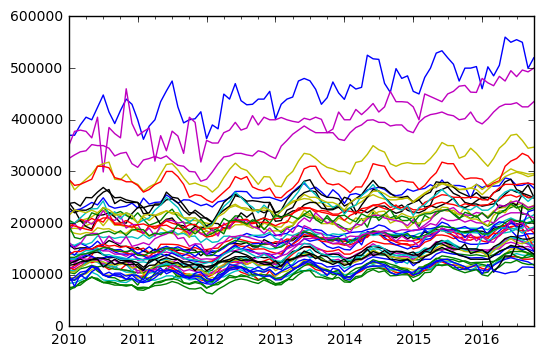

In [51]:
pm.data_hpa.hdfstore['state'].plot(legend=False)

Whoops. Those state values weren't transformed. Additionally, it seems I'm not handling the short lifespan of state data.

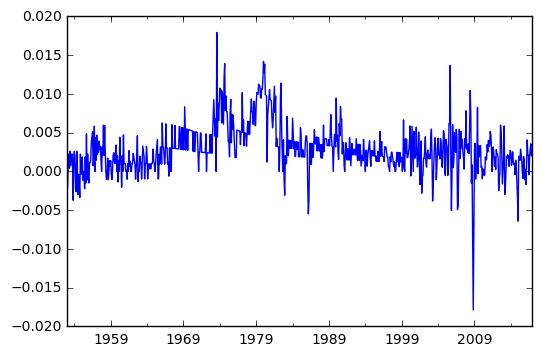

In [52]:
pm.data_hpa.hdfstore['cpi'].plot(legend=False)

## What's with the peaks on incentive?

These seem to be tied to peaks on `sato`, in that `wac` itself is peaky. Too bad I didn't store wac.

In [54]:
pm.data_pool.pools_table.shape[0] / 1000.

14151.800999999999

In [65]:
wac = [x for x in pm.data_pool.pools_table.read(step=5000, field='wac') if x < 99999]

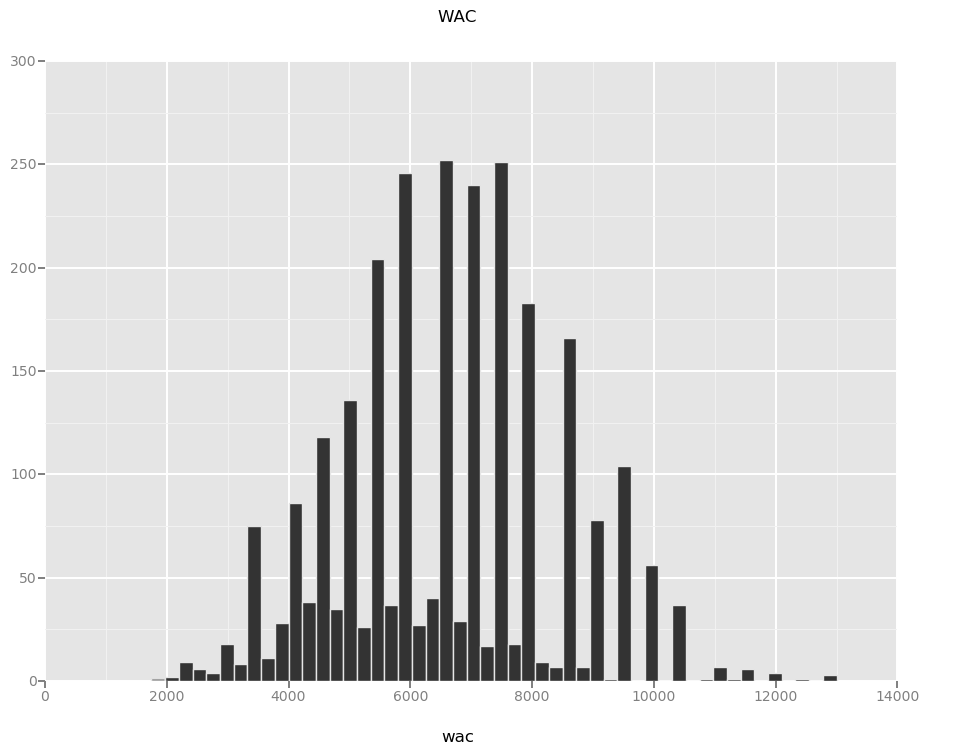

<ggplot: (8730264687473)>

In [66]:
gg.ggplot(pd.DataFrame(wac, columns=['wac']), gg.aes(x='wac')) + gg.geom_histogram(bins=50) + gg.ggtitle("WAC")

`wac` itself is peaky at 25bp intervals. Fair enough. Is `mean_wac` at the same scale?

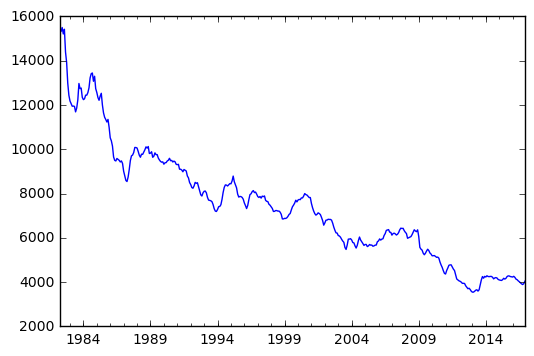

In [68]:
pd.Series(data = pm.data_pool.h5file.root.mean_wacs.values,
          index=pd.to_datetime(pm.data_pool.h5file.root.mean_wacs.index)).plot()

Yes.

# Scalars
Need to re-run the sampling after fixing HPA so I can determine the scalars.

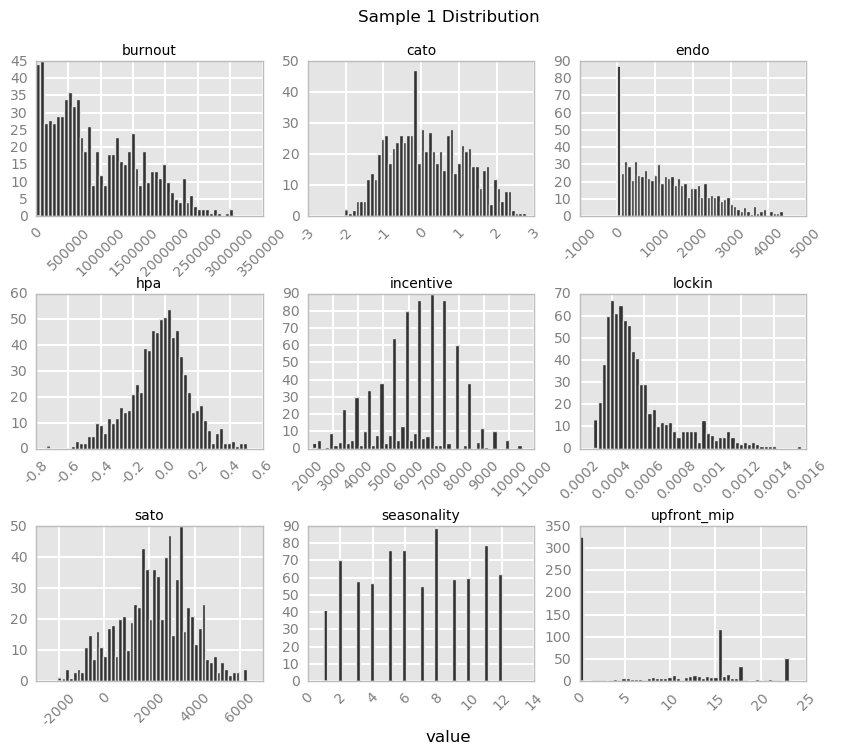

<ggplot: (8768207909709)>

In [12]:
p = gg.ggplot(pd.melt(data), gg.aes(x='value',group='variable')) + gg.facet_wrap(y='variable', scales="free")
p + gg.geom_histogram(bins=50) + gg.theme(x_axis_text=gg.element_text(angle=45)) + gg.ggtitle("Sample 1 Distribution")

In [25]:
scalars = pd.Series({'burnout':1e-7, 'cato':0.1, 'endo':1e-4, 'hpa':1, 'incentive':5e-5, 'lockin':200, 
                    'sato':1e-4, 'seasonality':1, 'upfront_mip':0.01})

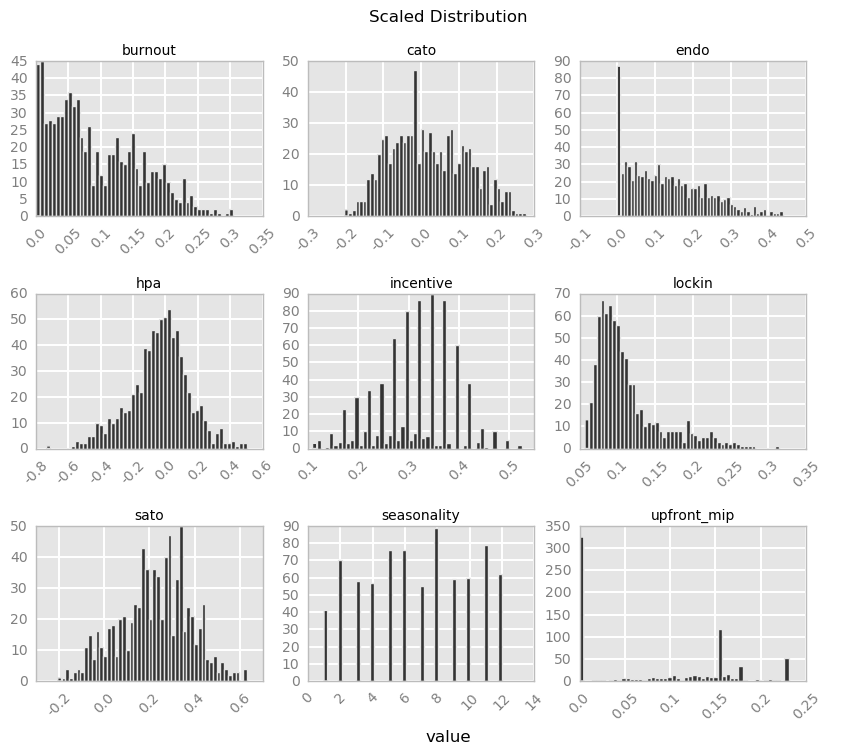

<ggplot: (8768244656909)>

In [26]:
p = gg.ggplot(pd.melt(data.mul(scalars)), gg.aes(x='value',group='variable')) + gg.facet_wrap(y='variable', scales="free")
p + gg.geom_histogram(bins=50) + gg.theme(x_axis_text=gg.element_text(angle=45)) + gg.ggtitle("Scaled Distribution")

Ok. Time to start on the modeling.

In [7]:
len(data)

999

In [8]:
import cPickle as pickle
pickle.dump(dict(data1=data,data2=data2), open("sample_data.pckl", "wb"))

NameError: name 'data2' is not defined